In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


# Intro
Hello! In this small notebook/tutorial we will look at the way we can use Hugging Face transformers for sentiment analysis. Hugging Face is a company that develops tools for building applications using machine learning. It is most notable for its transformers library built for natural language processing applications and its platform that allows users to share machine learning models and datasets.


The RoBERTa model is based and improves ob the BERT model. Bidirectional Encoder Representations from Transformers (BERT) is a family of language models introduced in 2018. 

It is a pretrained model,so we don't need to do any training, Hugging Faces will automatically download the model (the weights) and we can use them as it is. So we are doing transfer learning (TL) out of the box :)

We will use just a small fraction of the dataset at our disposal.

# Imports
We will add here all the imports that we need, this includes Hugging Faces transformers and other various utilities.

In [2]:
import bz2

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import softmax

from tqdm.notebook import tqdm

# add this for pandas, to better look at the data
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

# Loading the data
Now to load the data, for this dataset we have to do some extra work, as the data is archived (in bz2 format) and it has a lot of spaces that are not escaped.

The plan here is to open the file, read the data line by line and do some minor parsing. The parsed data we will keep and transform to a pandas data frame in order to work more easily.

As the data set is pretty big we will load just a small fraction of the dataset, this si sufficient for out test.

In [3]:
NUMBER_OF_LINES = 200

data = {}

for i, line in enumerate(bz2.open("/kaggle/input/amazonreviews/train.ft.txt.bz2", "rt", encoding="utf8")):

    if i == NUMBER_OF_LINES:
        break

    # label 1 is negativ and label 2 is positive
    label = 1 if line[:10] == "__label__1" else 2
    text = line[10:]

    localResult = {
        "label": label,
        "text": text
    }

    data[i] = localResult


df = pd.DataFrame(data).T
df = df.reset_index().rename(columns= {"index": "Id"})

# Quick EDA
Now let us take a quick look at the data, nothing fancy, just the shape and the distributions of the labels.

    Id label                                               text
0    0     2   Stuning even for the non-gamer: This sound tr...
1    1     2   The best soundtrack ever to anything.: I'm re...
2    2     2   Amazing!: This soundtrack is my favorite musi...
3    3     2   Excellent Soundtrack: I truly like this sound...
4    4     2   Remember, Pull Your Jaw Off The Floor After H...
5    5     2   an absolute masterpiece: I am quite sure any ...
6    6     1   Buyer beware: This is a self-published book, ...
7    7     2   Glorious story: I loved Whisper of the wicked...
8    8     2   A FIVE STAR BOOK: I just finished reading Whi...
9    9     2   Whispers of the Wicked Saints: This was a eas...
10  10     1   The Worst!: A complete waste of time. Typogra...
11  11     2   Great book: This was a great book,I just coul...
12  12     2   Great Read: I thought this book was brilliant...
13  13     1   Oh please: I guess you have to be a romance n...
14  14     1   Awful beyond belief!: I f

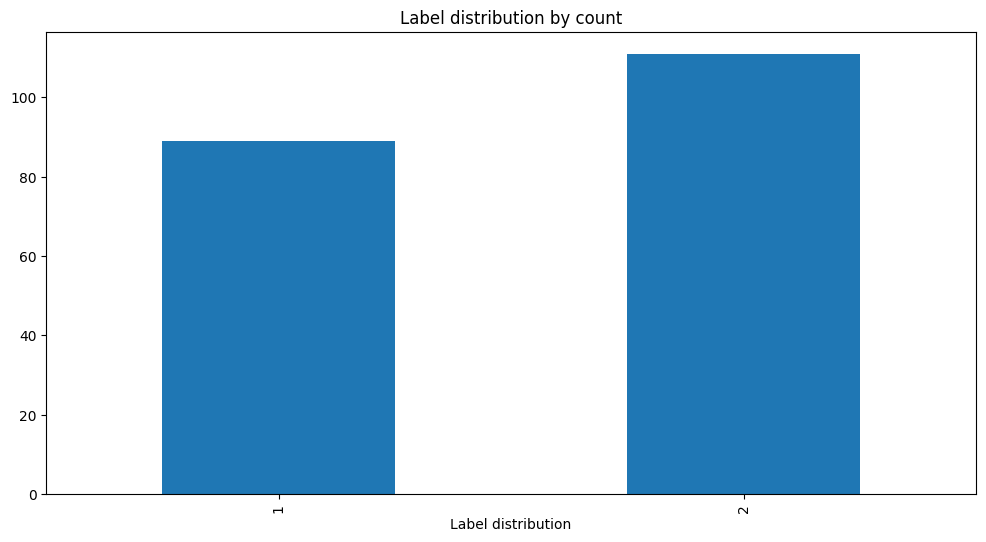

In [4]:
print(df.head(20))

print("the shape of the data", df.shape)

print("unique labels", df["label"].unique())

valueCounts = df["label"].value_counts().sort_index()
print(valueCounts)

ax = valueCounts.plot(kind="bar", title="Label distribution by count", figsize=(12, 6))
ax.set_xlabel("Label distribution")
plt.show()

# Semtiment prediction with ROBERTA transformer

In [5]:
modelName = "cardiffnlp/twitter-roberta-base-sentiment"

myTokenizer = AutoTokenizer.from_pretrained(modelName, max_length=512)
myModel = AutoModelForSequenceClassification.from_pretrained(modelName, max_length=512)

robertaResults = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text"]

    tokens = myTokenizer.__call__(text, return_tensors="pt", max_length=512, truncation=True)

    out = myModel(**tokens)
    scores = out[0][0].detach().numpy()

    softScores = softmax(scores)  # neg, neutral, positive

    robertaScores = {
        "roberta_negative": softScores[0],
        "roberta_neutral": softScores[1],
        "roberta_positive": softScores[2],
        "predicted_label": 1 if softScores[0] > softScores[2] else 2
    }

    robertaResults[i] = robertaScores

robertaDf = pd.DataFrame(robertaResults).T

robertaDf = robertaDf.reset_index().rename(columns= {"index": "Id"})

sentimentDf = robertaDf.merge(df, how="left")

print(sentimentDf.head())

  0%|          | 0/200 [00:00<?, ?it/s]

   Id  roberta_negative  roberta_neutral  roberta_positive  predicted_label label                                               text
0   0          0.003489         0.014600          0.981911              2.0     2   Stuning even for the non-gamer: This sound tr...
1   1          0.009733         0.052166          0.938101              2.0     2   The best soundtrack ever to anything.: I'm re...
2   2          0.004801         0.020830          0.974369              2.0     2   Amazing!: This soundtrack is my favorite musi...
3   3          0.001495         0.025328          0.973177              2.0     2   Excellent Soundtrack: I truly like this sound...
4   4          0.001908         0.017632          0.980459              2.0     2   Remember, Pull Your Jaw Off The Floor After H...


# Plotting the result

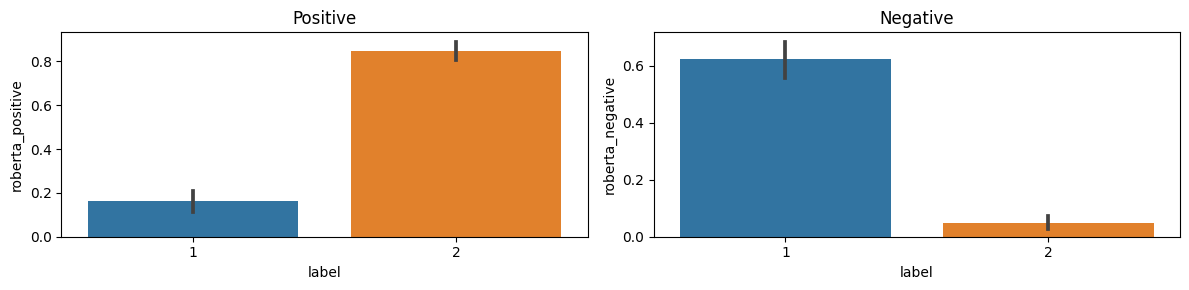

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
sns.barplot(data=sentimentDf, x='label', y='roberta_positive', ax=axs[0])
sns.barplot(data=sentimentDf, x='label', y='roberta_negative', ax=axs[1])
axs[0].set_title('Positive')
axs[1].set_title('Negative')
plt.tight_layout()
plt.show()

# General accuracy

In [7]:
correct = 0

for i, row in sentimentDf.iterrows():

    if row["label"] == int(row["predicted_label"]):
        correct += 1


accuracy = correct / len(sentimentDf)
print(f"accuracy is {accuracy}")

accuracy is 0.895


# Finish!
You have made it to the finish, please upvote if you liked this :)